# GCC218 - Algoritmos em Grafos

# Desafio - ShopMais

`Breno Oliveira - 201520629`

`Guilherme Baviera - 201420521`

`Guilherme Henrique Haddad - 201520615`

Repositório Oficial do Projeto: `https://github.com/brenoso/graph-theory-practical-challenge`

In [27]:
from IPython.display import HTML

# Youtube -> https://youtu.be/WzH8V5v7rtI
HTML('<iframe width="720" height="500" src="https://www.youtube.com/embed/WzH8V5v7rtI" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

# Fase 0

### - Leitura do arquivo de entrada
### - Sumarização
### - Visualização dos dados

In [1]:
import random

codigo = random.randint(1,1)
arquivo = "instancias/__" + str(codigo) + ".txt"

with open(arquivo) as file:
    N = int(file.readline())
    R = int(file.readline())
    K = int(file.readline())
    H = int(file.readline())
    centros_distribuicao = [file.readline().split() for i in range(R)]
    clientes = ["".join([file.readline(), "-1"]).split() for i in range(N-R)]
    vehicles = [file.readline().split(' ') for i in range(K)]

print("O arquivo sorteado para apresentação foi: " + arquivo)

O arquivo sorteado para apresentação foi: instancias/__1.txt


#### Exibição Inicial

Nesse bloco, serão mostrados:

`- Centro de Distribuição (vermelho)`

`- Cliente (azul)`

Isto ajuda a elucidar a distribuição dos clientes para esse problema.

In [2]:
from matplotlib import pyplot as plt
import random
#para todos os centros:
plt.scatter([float(x) for x,_,_,_,_ in centros_distribuicao], [float(y) for _,y,_,_,_ in centros_distribuicao], color='red')
#para todos os clientes
plt.scatter([float(x) for x,_,_,_,_,_ in clientes], [float(y) for _,y,_,_,_,_ in clientes], color='blue')


#axis = Define os limites do plano. Nesse caso é definido como igual tanto para min,máx dos eixos X e Y.
plt.axis('equal')

#xlabel ou xlabel = Define o "nome" de cada eixo, nesse caso mantemos como X e Y
plt.xlabel("x")
plt.ylabel("y")
#show = exibe a plotagem dos pontos no plano cartesiano
plt.show()

<Figure size 640x480 with 1 Axes>

# Fase 1

## Primeira Abordagem
Para cada `cliente (vértice)` calcule o `centro de distribuição` mais próximo.

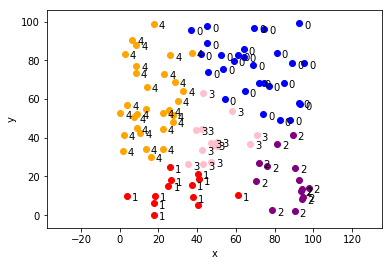

In [3]:
import sys
import math

colors = ['blue', 'red', 'purple', 'pink', 'orange']

#Fórmula para cálculo de distância Euclidiana entre dois pontos no plano cartesiano
def euclidian_distance(x1, y1, x2, y2):
    return math.sqrt((x2-x1)**2+(y2-y1)**2)

for i,[point_x,point_y,_,_,_,_] in enumerate(clientes):
    menor = sys.maxsize
    for j,[centros_distribuicao_x,centros_distribuicao_y,_,_,_] in enumerate(centros_distribuicao):
        if euclidian_distance(float(point_x), float(point_y), float(centros_distribuicao_x), float(centros_distribuicao_y)) < menor:
            menor = euclidian_distance(float(point_x), float(point_y), float(centros_distribuicao_x), float(centros_distribuicao_y))
            clientes[i][5] = j

for idx,[x,y,_,_,_] in enumerate(centros_distribuicao):
    plt.scatter(float(x), float(y), color=colors[idx])

for x,y,_,_,_,dist in clientes:
    plt.scatter(float(x), float(y), color=colors[dist])
    
for p in clientes:
    plt.annotate(p[5], xy=(float(p[0]),float(p[1])), xytext=(5,-5), textcoords='offset points')
    
plt.axis('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## Segunda Abordagem

Utilizar o `diagrama de Voronoi` para `clusterizar` as regiões

Mais informações, leia: https://pt.wikipedia.org/wiki/Diagrama_de_Voronoy

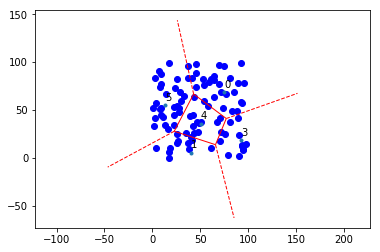

In [4]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import numpy as np

vor = Voronoi([(float(x),float(y)) for x,y,_,_,_ in centros_distribuicao])
voronoi_plot_2d(vor, line_colors='red', show_vertices=False)

for idx,d in enumerate(centros_distribuicao):
    plt.annotate(vor.point_region[idx], xy=(float(d[0]),float(d[1])), xytext=(0,5), textcoords='offset points')
    
for x,y,_,_,_,_ in clientes:
    plt.scatter(float(x), float(y), color='blue')
plt.axis('equal')

plt.show()

point = Point(0, 0)
polygon = Polygon([vor.vertices[i] for i in vor.regions[5] if not i == '-1'])

## Heurística para transformação para `regiões finitas`

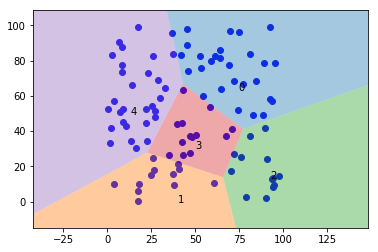

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon

def voronoi_with_finite_polygons(vor):
    """
    
    """

    new_regions = []
    # Vértices do diagrama de voronoi
    new_vertices = vor.vertices.tolist()
    # Ponto médio entre os centros de distribuição
    center = vor.points.mean(axis=0)
    
    # Atualiza raio que dará a posição do vértice, d'antes infinito, no novo polígono
    radius = vor.points.ptp().max()*2

    # Estrutura para armazenar os vértices de voronoi que se cruza ao sair de um ponto de distribuição para um outro qualquer de região vizinha
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
        
    # Cálculo das regiões infinitas
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        
        # Se nenhum dos pontos da região possui um vértice no infinito
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]

        # Vértices que não estão no infinito
        new_region = [v for v in vertices if v >= 0]
        
        for idx, [p2, v1, v2] in enumerate(ridges):
            #print(p1, p2, v1, v2)
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # Ridge finita que já consta na região
                continue

            # Computa os pontos infinitos na região
            t = vor.points[p2] - vor.points[p1] # tangente
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            # Atualiza all_ridges com os novos vértices calculados
            v1 = len(new_vertices)
            ridges[idx] = [p2, v1, v2]
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        
        # Ordena as regiões de forma anti-horária
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices), all_ridges

dists = np.array([[float(x),float(y)] for x,y,_,_,_ in centros_distribuicao])

# Cria diagrama de Voronoi
vor = Voronoi(dists)

# Transforma pontos infinitos em finitos
regions, vertices, all_ridges = voronoi_with_finite_polygons(vor)

# TODO: pegar valor max e min dos pontos de entrega e não dos pontos de distribuição
min_x = vor.min_bound[0] - 1000
max_x = vor.max_bound[0] + 1000
min_y = vor.min_bound[1] - 1000
max_y = vor.max_bound[1] + 1000

mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
bounded_vertices = np.max((vertices, mins), axis=0)
maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
bounded_vertices = np.min((bounded_vertices, maxs), axis=0)

# Polígono geral do gráfico
box = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

new_regions = []

for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]
    new_regions.append(poly)

    plt.fill(*zip(*polygon), alpha=0.4)

new_points = []
# Plota os pontos de entrega
for x,y,_,_,_,_ in clientes:
    plt.scatter(float(x), float(y), color='blue')
    for idx,region in enumerate(new_regions):
        if region.contains(Point(float(x), float(y))):
            # Imprime índice da região do ponto
            new_points.append([x,y,idx])
            #print(idx)


# Plota os indices das regiões
for idx,[x,y] in enumerate(dists):
    plt.annotate(idx, xy=(x,y), xytext=(0,-10), textcoords='offset points')

plt.axis('equal')
plt.xlim(vor.min_bound[0] - 20.1, vor.max_bound[0] + 20.1)
plt.ylim(vor.min_bound[1] - 20.1, vor.max_bound[1] + 40.1)

plt.show()

# Fase 1

## Clientes

Após a leitura e preparação dos dados importados do `.txt` da entrada do problema
é instanciado uma lista de objetos do tipo Cliente.           

In [6]:
from cliente import Cliente

lista_de_clientes = []

for idx, point in enumerate(clientes):
    coordernadas = []
    coordernadas.append(point[0])
    coordernadas.append(point[1])
    volume = float(point[2])
    volume = round(volume, 8)
    preco_mercadoria = float(point[3])
    qtd_pacotes = float(point[4])
    regiao = point[5]
    
    #Criada lista de Objetos do Tipo CLIENTE
    lista_de_clientes.append(Cliente(coordernadas, volume, preco_mercadoria, qtd_pacotes, regiao, idx))

In [7]:
#Feita uma conferência dentre todos os clientes quais estão em quais regiões.
#O somatório é salvo dentro de uma lista que vai de 0 a 4 (qtd de centros)
clientes_de_cada_centro = []
for idx in range(0, 4):
    clientes_do_centro = []
    for cliente in lista_de_clientes:
        if cliente.get_centro() == idx:
            clientes_do_centro.append(cliente)
    clientes_de_cada_centro.append(clientes_do_centro)

#Verifica qual cliente pertence a qual centro, após isso é inserida a lista criada acima com os todos os vertices do centro
#A partir dessa informação é calculada a distancia de cada cliente para todos os demais, gerando assim a informação de um "grafo completo", no qual as arestas são as distâncias encontradas
for idx in range(0, 4):
    for cliente in lista_de_clientes:
        if cliente.get_centro() == idx:
            cliente.set_distancia_para_vizinhos(clientes_de_cada_centro[idx])

In [8]:
#Sobrecarga da função __str__ para exibir os dados para visualização no Notebook

[print(cliente) for cliente in lista_de_clientes];
#Obs: adicionado ; após essa linha, pois no Jupyter imprime 2x quando ele não está presente

Cliente: 0	 Centro de Atendimento: 2	 Volume Pedido: 0.006231	 Qtd Pacotes: 10.0
Cliente: 1	 Centro de Atendimento: 4	 Volume Pedido: 0.004195	 Qtd Pacotes: 1.0
Cliente: 2	 Centro de Atendimento: 2	 Volume Pedido: 0.006345	 Qtd Pacotes: 3.0
Cliente: 3	 Centro de Atendimento: 4	 Volume Pedido: 0.007504	 Qtd Pacotes: 8.0
Cliente: 4	 Centro de Atendimento: 1	 Volume Pedido: 0.008467	 Qtd Pacotes: 11.0
Cliente: 5	 Centro de Atendimento: 4	 Volume Pedido: 0.006674	 Qtd Pacotes: 1.0
Cliente: 6	 Centro de Atendimento: 1	 Volume Pedido: 0.002503	 Qtd Pacotes: 7.0
Cliente: 7	 Centro de Atendimento: 1	 Volume Pedido: 0.004501	 Qtd Pacotes: 6.0
Cliente: 8	 Centro de Atendimento: 1	 Volume Pedido: 0.001568	 Qtd Pacotes: 3.0
Cliente: 9	 Centro de Atendimento: 0	 Volume Pedido: 0.007944	 Qtd Pacotes: 9.0
Cliente: 10	 Centro de Atendimento: 1	 Volume Pedido: 0.003518	 Qtd Pacotes: 5.0
Cliente: 11	 Centro de Atendimento: 3	 Volume Pedido: 0.0015	 Qtd Pacotes: 2.0
Cliente: 12	 Centro de Atendimento: 3	

Foi utilizada a heurística de `vizinho mais próximo` para determinar qual Centro de Distribuíção irá atender um determinado cliente. A partir dessa abordagem, foi salvo um indicador em cada cliente para identificar melhor a região.

Formando assim o nosso grafo com vértices do tipo `CLIENTE` e `CENTRO`

## Centros

Para cada entrada disponível no arquivo `.txt` é criado um objeto do tipo Cliente.

In [9]:
from centro import Centro
from tabulate import tabulate

#Instancia os centros de distribuicao
lista_de_centros = []

for idx, center in enumerate(centros_distribuicao):
    coordenadas = []
    coordenadas.append(center[0])
    coordenadas.append(center[1])
    clientes_do_centro = []
    #  Pega todos os clientes que pertencem ao centro em questao
    clientes_do_centro = [cliente for cliente in lista_de_clientes if cliente.get_centro() == idx]
    label = idx

    lista_de_centros.append(Centro(coordenadas, clientes_do_centro, label))

In [10]:
#Sobrecarga da função __str__ para exibir os dados para visualização no Notebook

[print(centro) for centro in lista_de_centros];
#Obs: adicionado ; após essa linha, pois no Jupyter imprime 2x quando ele não está presente

Centro: 0	 Qtd de Cliente: 28	 Volume Total: 0.147625
Centro: 1	 Qtd de Cliente: 12	 Volume Total: 0.063389
Centro: 2	 Qtd de Cliente: 13	 Volume Total: 0.07799700000000001
Centro: 3	 Qtd de Cliente: 13	 Volume Total: 0.07116199999999999
Centro: 4	 Qtd de Cliente: 29	 Volume Total: 0.19450699999999996


# `TODO`

## Heurística para melhoramento das divisões das regiões

A ideia utilizada:

1. Ordenar as regiões, de forma decrescente, de acordo com a quantidade de pontos de entrega contidos nas mesmas.

2. As regiões com mais pontos irão _doar_ os pontos mais próximos de outra região com menos pontos

## Veículos

Cada registro de veículo disponível no arquivo `.txt` é criado um obejto do tipo Veiculo

In [11]:
from veiculo import Veiculo

lista_de_veiculos = []

for idx, veiculo in enumerate(vehicles):

    volume_maximo_suportado = float(veiculo[0])
    volume_maximo_suportado = round(volume_maximo_suportado, 8)
    valor_maximo_suportado = float(veiculo[1])
    velocidade_inicial_final = float(veiculo[3])
    velocidade_normal = float(veiculo[4])
    tempo_carga = float(veiculo[5])
    tempo_descarga = float(veiculo[6])
    custo_medio_hora = float(veiculo[7])
    custo_medio_km = float(veiculo[8])
    custo_fixo_diario = float(veiculo[9])

    quantidade_veiculos_disponiveis = int(veiculo[2]) #Quantidade de veiculo disponivel de cada tipo

    tipos = {0 : 'Van',
           1 : 'Mini-Van',
           2 : 'Comum',
           3 : 'Motocicleta',
           4 : 'Van terceirizada'}

    tipo_veiculo = tipos.get(idx)

    # Para a quantidade de veiculo de cada tipo, cria os respectivos veiculos
    for veiculos in range(quantidade_veiculos_disponiveis):
        lista_de_veiculos.append(Veiculo(volume_maximo_suportado, valor_maximo_suportado,
                                               velocidade_inicial_final, velocidade_normal,
                                                tempo_carga, tempo_descarga, custo_medio_hora,
                                                custo_medio_km, custo_fixo_diario, tipo_veiculo))

In [12]:
#Sobrecarga da função __str__ para exibir os dados para visualização no Notebook

[print(veiculo) for veiculo in lista_de_veiculos];
#Obs: adicionado ; após essa linha, pois no Jupyter imprime 2x quando ele não está presente

Veículo: Van
	Custo dia: 125.0	Custo km: 3.0	Custo hora: 44.0
	Vol. Máximo: 15.0	Valor. Máximo: 74907.0
	Vel. Ini/Fin: 28.0	Vel. Normal: 29.0
Veículo: Van
	Custo dia: 125.0	Custo km: 3.0	Custo hora: 44.0
	Vol. Máximo: 15.0	Valor. Máximo: 74907.0
	Vel. Ini/Fin: 28.0	Vel. Normal: 29.0
Veículo: Van
	Custo dia: 125.0	Custo km: 3.0	Custo hora: 44.0
	Vol. Máximo: 15.0	Valor. Máximo: 74907.0
	Vel. Ini/Fin: 28.0	Vel. Normal: 29.0
Veículo: Van
	Custo dia: 125.0	Custo km: 3.0	Custo hora: 44.0
	Vol. Máximo: 15.0	Valor. Máximo: 74907.0
	Vel. Ini/Fin: 28.0	Vel. Normal: 29.0
Veículo: Van
	Custo dia: 125.0	Custo km: 3.0	Custo hora: 44.0
	Vol. Máximo: 15.0	Valor. Máximo: 74907.0
	Vel. Ini/Fin: 28.0	Vel. Normal: 29.0
Veículo: Van
	Custo dia: 125.0	Custo km: 3.0	Custo hora: 44.0
	Vol. Máximo: 15.0	Valor. Máximo: 74907.0
	Vel. Ini/Fin: 28.0	Vel. Normal: 29.0
Veículo: Van
	Custo dia: 125.0	Custo km: 3.0	Custo hora: 44.0
	Vol. Máximo: 15.0	Valor. Máximo: 74907.0
	Vel. Ini/Fin: 28.0	Vel. Normal: 29.0
Veícul

## Distribuição dos Veículos entre os Centros de Distribuição

### Cálculo de Distribuição

`Calcula para cada tipo de veiculo, o total de veiculos por centro. Também faz o calculo dos veiculos que 'sobrarão' caso a conta não dê valores exatos. Esses veículos 'sobressalentes' serão alocados de uma maneira mais eficiente de acordo com a demanda de cada centro`

In [13]:
total_veiculos_por_tipo = []

for idx, veiculo in enumerate(vehicles):

    total_veiculos_por_tipo.append(float(veiculo[2]))

 # Os veiculos sobressalentes cujas divisões não resultaram em numeros inteiros
 # serão alocados posteriormente para os centros com maior demanda um a um, do maior para o menor
total_veiculos_por_tipo_por_centro = []
total_veiculos_por_tipo_sobressalentes = [0,0,0,0,0] # Os veiculos que sobrarem da divisão serão armazenados aqui

for idx, veiculos in enumerate(total_veiculos_por_tipo):
    
    # Se a divisão for inteira, armazena a quantidade exata de veiculos pra cada centro
    if (veiculos % len(centros_distribuicao) == 0):
        total_veiculos_por_tipo_por_centro.append(veiculos / len(centros_distribuicao))

    # Se a divisão der resto, armazena o valor mais próximo abaixo que a divisão dá inteira e
    # adiciona os veiculos que sobrarem na lista de veiculos sobressalentes, para serem distribuidos depois
    else:
        resto = veiculos % len(centros_distribuicao)
        total_veiculos_por_tipo_sobressalentes[idx] = resto
        veiculos_inteiros = veiculos - resto
        total_veiculos_por_tipo_por_centro.append(veiculos_inteiros / len(centros_distribuicao))


In [14]:
tipos = {0 : 'Van',
        1 : 'Mini-Van',
        2 : 'Comum',
        3 : 'Motocicleta',
        4 : 'Van terceirizada'}


# Cria e popula uma lista de veiculos separados por seus tipos
lista_veiculos_por_tipo = []
for idx in range(len(tipos)):
    lista_veiculos_por_tipo.append([veiculo for veiculo in lista_de_veiculos if veiculo.get_tipo_de_veiculo() == tipos.get(idx)])

### Efetua a alocação dos veiculos 'inteiros' para cada centro.

In [15]:
# Cria e popula uma lista de veiculos separados por seus tipos
lista_veiculos_por_tipo = []
for idx in range(len(tipos)):
    lista_veiculos_por_tipo.append([veiculo for veiculo in lista_de_veiculos if veiculo.get_tipo_de_veiculo() == tipos.get(idx)])

# Aloca os veiculos 'inteiros' em ordem do tipo de veiculo nos centros (setando os labels dos respectivos centros)
for tipo_veiculo in range(len(tipos)):
    
    label_centro = 0

    # Numero de veiculos do tipo em questao que serao alocados POR CENTRO
    contador_por_centro = total_veiculos_por_tipo_por_centro[tipo_veiculo]

    # Numero TOTAL de veiculos do tipo em questao que serao alocados
    quantidade_veiculos_alocar = len(lista_veiculos_por_tipo[tipo_veiculo]) - int(total_veiculos_por_tipo_sobressalentes[tipo_veiculo])

    # Para cada um dos veiculos totais a serem alocados, lembrando que os veiculos totais
    # podem não ser todos os veiculos desse tipo, pois os sobressalente serão alocados posteriormente
    for idx in range(quantidade_veiculos_alocar):

        # Aloca o veiculo para o centro
        lista_veiculos_por_tipo[tipo_veiculo][idx].set_alocacao(lista_de_centros[label_centro])

        # Essa variavel será decrementada até que chegue a 0, onde
        # então significará que o numero de veiculos por centro alocados já foi atingido
        # e poderemos passar a alocar os próximos veiculos para os proximos centros
        contador_por_centro = contador_por_centro - 1

        if (contador_por_centro == 0):
            contador_por_centro = total_veiculos_por_tipo_por_centro[tipo_veiculo]
            label_centro = label_centro + 1


### Efetua a alocação dos veiculos 'sobressalentes' para cada centro.

In [16]:
# Pega os veiculos que não estão em nenhum centro
veiculos_sem_alocacao = [veiculo for veiculo in lista_de_veiculos if veiculo.get_centro() is None]

# Agrupa os veiculos que não estão em nenhum centro por Tipo
veiculos_sem_alocacao_por_tipo = []
for idx in range(len(tipos)):
    veiculos_sem_alocacao_por_tipo.append([veiculo for veiculo in veiculos_sem_alocacao if veiculo.get_tipo_de_veiculo() == tipos.get(idx)])

# Elimina os tipos de veiculos que não contem veiculos sem centro, caso haja
veiculos_sem_alocacao_por_tipo = [x for x in veiculos_sem_alocacao_por_tipo if len(x) is not 0]

# Ordena a lista de centros baseado em dois valores: valor_total_todos_clientes e volume_total. Assim poderemos
# distribuir os veiculos sobressalentes de forma otimizada entre os centros com demanda maior
lista_de_centros_ordenadas = sorted(lista_de_centros, key = lambda x: (x.get_valor_total_todos_clientes(), x.get_volume_total()), reverse=True)

# Aloca os veiculos 'sobressalentes' para os centros em ordem decrescente de demanda. Ou seja,
# para cada tipo de veiculo teremos no máximo 4 (menor numero não divisivel pelo numero de centros) veiculos sobressalentes,
# então, para cada tipo de veiculo, o centro com maior demanda receberá um veiculo, seguido pelo 
# segundo centro de maior demanda, até esgotarem os veiculos para cada tipo, que serão no máx 4, visto que são 5
# centros no total.
for i in range(len(veiculos_sem_alocacao_por_tipo)):
    for j in range(len(veiculos_sem_alocacao_por_tipo[i])):
        veiculos_sem_alocacao_por_tipo[i][j].set_alocacao(lista_de_centros_ordenadas[j])

# Verifica se algum veiculo não foi alocado para algum centro
veiculos_sem_alocacao = [veiculo for veiculo in lista_de_veiculos if veiculo.get_centro() is None]

print("Veículos não preparados para ser alocado para algum centro: " + str(len(veiculos_sem_alocacao)))

Veículos não preparados para ser alocado para algum centro: 0


`Efetua a alocação dos veiculos nos objetos Centro`

In [17]:
for veiculo in lista_de_veiculos:
    label_centro = veiculo.get_centro()
    centro = [centro for centro in lista_de_centros if centro.get_label() == label_centro]
    centro[0].set_veiculo(veiculo)
    
for centro in lista_de_centros:
    print(centro.imprime_veiculos_alocados())

+---------------------------------------------------------------------------------------------+
|                                           Centro 0                                          |
+------------------+--------------------+-----------------+-----------+----------+------------+
|       Tipo       | Jornada Disponível | Volume em Carga | Custo Dia | Custo Km | Custo Hora |
+------------------+--------------------+-----------------+-----------+----------+------------+
| Van terceirizada |      7h 0m 0s      |        0        |    0.0    |   2.0    |    0.0     |
| Van terceirizada |      7h 0m 0s      |        0        |    0.0    |   2.0    |    0.0     |
| Van terceirizada |      7h 0m 0s      |        0        |    0.0    |   2.0    |    0.0     |
| Van terceirizada |      7h 0m 0s      |        0        |    0.0    |   2.0    |    0.0     |
| Van terceirizada |      7h 0m 0s      |        0        |    0.0    |   2.0    |    0.0     |
| Van terceirizada |      7h 0m 0s      

## Conclusão Fase 1

Pelas nossas análises, os pontos que levamos em conta para efetuar a `alocação ideal` dos `veiculos` para cada `cluster (Centro de Distribuição)` seriam o `Volume Máximo Suportado` e o `Valor Máximo Suportado` por cada veiculo em relação ao `Valor Total` e o `Volume Total` de todos os clientes que compõe a cada Centro. 

Sendo assim, a ideia é tentar distribuir os veículos nos centros de modo a nunca faltar veiculos para cada centro e chegar o mais próximo do mínimo de veículos por centro. 

Porém pelas instâncias geradas pelo gerador, notamos que teríamos uma enorme folga em relação as capacidades dos veículos com a demanda total de cada centro (total dos clientes), levando em conta o volume máximo e o valor máximo de cada cliente. 

`Decidimos dividir os veiculos igualmente entre os centros de distribuição de forma que a divisão poderá gerar veículos 'sobressalentes', que representam o resto da divisão dos veículos pelos centros de distribuição. Os veiculos que restarem serão divididos de forma a otimizar as necessidades de cada centro, onde serão consideradas as demandas de cada centro, e eles serão alocados um a um para os centros em ordem de maior demanda.`


# Fase 2

## Problema do Caixeiro Viajante - TSP

#### Propósitos:

`- O caixeiro deve visitar todas as cidades`

`- Passando uma só vez em cada cidade`

`- Com o menor custo possível`


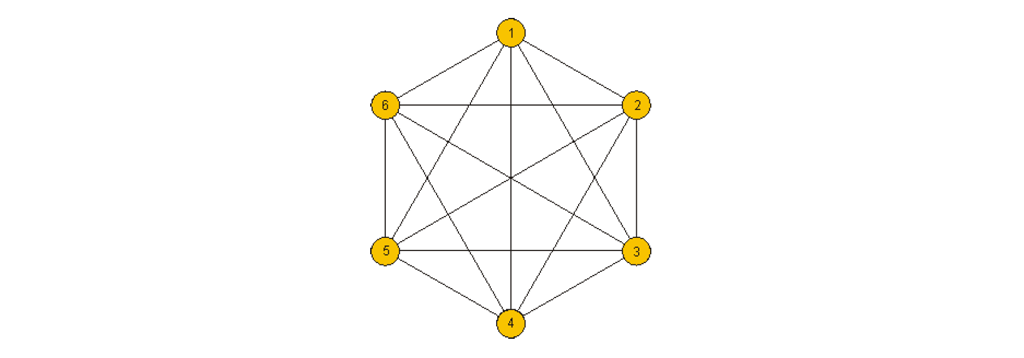


#### O problema a ser resolvido:

Contém um conjunto de restrições Ω (Volume, valor, tempo).

No TSP, as restrições são:

(i) cada vértice só pode ser visitado uma vez [para esse cenário a definição de "visitado uma vez" é valida para quando sua demanda for totalmente entregue, ou seja, ele pode ser visitado mais de uma vez até que seja totalmente entregue seu pedido.]

(ii) todos os vértices devem ser visitados.




## Problema da Colônia de Formigas


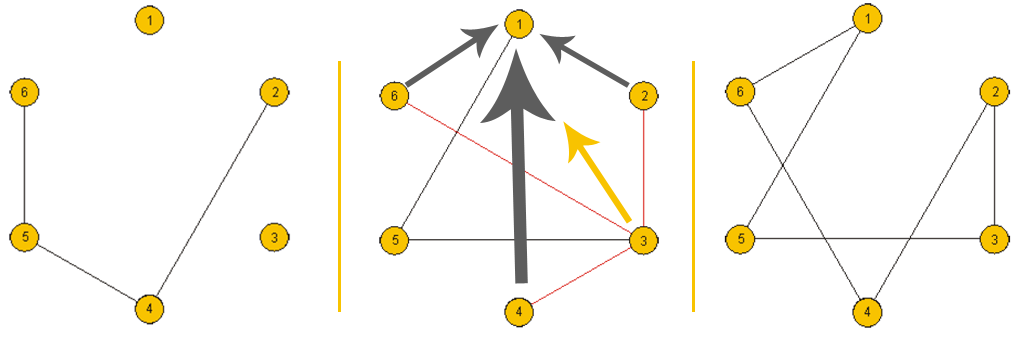

No algoritmo de colônia de formigas:

`- Cada formiga possui um estado inicial, do qual ela parte. Geralmente, esse estado inicial é composto apenas pelo nó no qual a formiga está quando começa a andar.`

`- As formigas se comunicam apenas através do feromôniodeixado pelo caminho.`

`- Cada formiga constrói uma sequência de estados, incluindo um nó por vez.`

`- A formiga tem uma memória L que a permite reconstruir o caminho percorrido até o momento.`

`- Quando está em um estado r, a formiga pode mover-se para qualquer nó de sua vizinhança factível.`

`- A formiga possui condições de parada, que estão associadas à obtenção de uma solução factível para o problema.`



A partir desse conceituação do problema, aplicamos essa base para resolução do desafio proposto.


### 1 - Roteirização

In [18]:
for centro in lista_de_centros:

    veiculos = centro.get_veiculos()
    veiculos_ordenados = sorted(veiculos, key = lambda x: (x.get_custo_por_hora(), x.get_custo_por_dia()), reverse=True)
    
    for veiculo in veiculos_ordenados:

        while (veiculo.is_disponivel_para_trajeto()):
            local_atual = veiculo.get_localizacao_atual() 

            ### INICIO TSP ###
            vizinhos = local_atual.get_distancias_vizinhos()

            # Filtra os vizinhos para que não apareça a distancia do vertice para ele mesmo,
            # pois essa será sempre 0
            vizinhos = [x for x in vizinhos if x[1] > 0]

            posicao_vizinhos_ordenados = sorted(vizinhos, key = lambda x: (x[1]))

            vizinhos_mais_proximos = list()
            for idx in range(len(posicao_vizinhos_ordenados)):
                posicao = posicao_vizinhos_ordenados[idx][0]
                vizinhos_mais_proximos.append(lista_de_clientes[posicao])
            
            vizinhos_mais_proximos = [vizinho for vizinho in vizinhos_mais_proximos if vizinho.tem_demanda()]
            ### FIM TSP ###

            if (vizinhos_mais_proximos):

                for idx, vizinho in enumerate(vizinhos_mais_proximos):
                    
                    # Veiculo, de onde vc está, é possível ir até esse vizinho e volta para o centro?
                    if (veiculo.is_trajeto_possivel(vizinho, centro)):

                        # Veiculo que tem o tempo esgado, volta para o centro!
                        if (veiculo.is_tempo_esgotado(centro)):

                            # Realizar debitos do caminho de volta do veiculo para o centro
                            distancia_cliente_centro = centro.get_distancia_centro_ao_cliente(veiculo.get_localizacao_atual().get_label())
                            tempo_retorno_centro = (distancia_cliente_centro[0] / veiculo._velocidade_inicial_final) * 120
                            veiculo.debita_tempo_jornada(veiculo.get_tempo_jornada_disponivel() - tempo_retorno_centro)

                            veiculo.atualizar_localizacao_atual(centro)
                            veiculo._disponivel_para_trajeto = False

                        break
                    
                    # Não foi encontrado um trajeto que atenda aos três requisitos: volume, valor e tempo
                    # Porém o veiculo tem tempo disponivel para mais entregas, então ele voltará ao centro,
                    # reporá seu estoque e iniciará um novo trajeto para os clientes restantes
                    elif (idx == len(vizinhos_mais_proximos) - 1):

                        # Realizar debitos do caminho de volta do veiculo para o centro
                        if (veiculo.get_localizacao_atual() is not centro):

                            distancia_cliente_centro = centro.get_distancia_centro_ao_cliente(veiculo.get_localizacao_atual().get_label())
                            
                            tempo_retorno_centro = (distancia_cliente_centro[0] / veiculo._velocidade_inicial_final) * 120
                            
                            veiculo.debita_tempo_jornada(veiculo.get_tempo_jornada_disponivel() - round(tempo_retorno_centro, 0))
                            veiculo.atualizar_localizacao_atual(centro)
                            veiculo.reset_volume_maximo_suportado()
                            veiculo.reset_valor_maximo_suportado()

                        else:
                            veiculo._disponivel_para_trajeto = False

            else:
                veiculo._disponivel_para_trajeto = False
                break

# Situação dos Clientes

Após ser executado o TSP, os clientes ficam com os seguinte formato:

In [19]:
from prettytable import PrettyTable

tabela_clientes = PrettyTable()
tabela_clientes.title = "Clientes"
tabela_clientes.field_names = ['Cliente', 'Coordenada X', 'Coordenada Y', 'Centro', 'Volume a Entregar']

for cliente in lista_de_clientes:
    coordenadas = cliente.get_coordenadas()
    tabela_clientes.add_row([cliente.get_label(), coordenadas[0], coordenadas[0], cliente.get_centro(), cliente.get_volume_total()])
    tabela_clientes.sortby = "Centro"
print(tabela_clientes)

+--------------------------------------------------------------------------------+
|                                    Clientes                                    |
+---------+--------------------+--------------------+--------+-------------------+
| Cliente |    Coordenada X    |    Coordenada Y    | Centro | Volume a Entregar |
+---------+--------------------+--------------------+--------+-------------------+
|    9    | 64.60041835637256  | 64.60041835637256  |   0    |        0.0        |
|    13   | 74.68069248398862  | 74.68069248398862  |   0    |        0.0        |
|    22   | 54.26277195310043  | 54.26277195310043  |   0    |        0.0        |
|    23   | 74.10314953218008  | 74.10314953218008  |   0    |        0.0        |
|    24   | 71.99927693492747  | 71.99927693492747  |   0    |        0.0        |
|    25   | 61.16183293097489  | 61.16183293097489  |   0    |        0.0        |
|    26   | 82.70139193800394  | 82.70139193800394  |   0    |        0.0        |
|   

+---------+--------------------+--------------------+--------+-------------------+


# Situação dos Veículos

Após serem feitas as entregas, os veículos de cada região estão da seguinte forma.

In [20]:
for veiculo in lista_de_veiculos:
    label_centro = veiculo.get_centro()
    centro = [centro for centro in lista_de_centros if centro.get_label() == label_centro]
    centro[0].set_veiculo(veiculo)
    
for centro in lista_de_centros:
    print(centro.imprime_veiculos_alocados())

+--------------------------------------------------------------------------------------------------------+
|                                                Centro 0                                                |
+------------------+-------------------------------+-----------------+-----------+----------+------------+
|       Tipo       |       Jornada Disponível      | Volume em Carga | Custo Dia | Custo Km | Custo Hora |
+------------------+-------------------------------+-----------------+-----------+----------+------------+
| Van terceirizada |            7h 0m 0s           |        0        |    0.0    |   2.0    |    0.0     |
| Van terceirizada |            7h 0m 0s           |        0        |    0.0    |   2.0    |    0.0     |
| Van terceirizada |            7h 0m 0s           |        0        |    0.0    |   2.0    |    0.0     |
| Van terceirizada |            7h 0m 0s           |        0        |    0.0    |   2.0    |    0.0     |
| Van terceirizada |            7h 0m

# Situação dos Trajetos dos Veículos

Trajetos salvos feitos pelos veículos

In [22]:
from prettytable import PrettyTable

tabela_veiculos = PrettyTable()

tabela_veiculos.field_names = ['Centro', 'Tipo', 'Volume', 'Jornada']

for idx,veiculo in enumerate(lista_de_veiculos, ):
    tabela_veiculos.title = "Trajetos - Veículo " + str(idx) + " - Tipo: " + veiculo.get_tipo_de_veiculo()
    for idxt,trajeto in enumerate(veiculo.get_trajeto_feito()):
        tabela_veiculos.add_row([trajeto.get_label(), str(type(trajeto)), trajeto.get_volume_total(), veiculo.converte_segundos_em_tempo()])

    print(tabela_veiculos)
##    tabela_veiculos.clear_rows()

+------------------------------------------------------------------------------+
|                       Trajetos - Veículo 0 - Tipo: Van                       |
+--------+---------------------------+----------+------------------------------+
| Centro |            Tipo           |  Volume  |           Jornada            |
+--------+---------------------------+----------+------------------------------+
|   0    |  <class 'centro.Centro'>  | 0.147625 | 6.0h 55.0m 1.69567127152186s |
|   80   | <class 'cliente.Cliente'> |   0.0    | 6.0h 55.0m 1.69567127152186s |
+--------+---------------------------+----------+------------------------------+
+--------------------------------------------------------+
|            Trajetos - Veículo 1 - Tipo: Van            |
+--------+-------------------------+----------+----------+
| Centro |           Tipo          |  Volume  | Jornada  |
+--------+-------------------------+----------+----------+
|   0    | <class 'centro.Centro'> | 0.147625 | 7h 0m 0s 

## Conclusão Fase 2

Após executar alguns testes com instâncias diferentes, vimos que por se tratar de uma heuristica a implementação precisa de levar em conta muitos aspectos que possam ser "normais" ao contexto. A alteração do cenário pode impactar na solução porém existem formas de melhorar a heuristica para que ela se adapte e entregue o resultado mais próximo do "ótimo".

#### Bibliotecas utilizadas

`Matplotlib`

`PrettyTable 7`

`PTable 0.9.2`